## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from tqdm import tqdm

# 2. Utility Function Helpers

In [2]:

def mp_model_ppsoe(inv, mult, phi, theta):
    inv = float(inv)
    mult = float(mult)
    exp = float(2*inv)
    theta = float(theta)
    phi = float(phi)
    total_amt = inv*mult
    choice_opts = np.arange(0, total_amt+1)  # Only integers in strategy space (but not further discretized)
    own = total_amt-choice_opts
    other = 10 - inv + choice_opts
    own_share = own/total_amt # Should be total_amt
    guilt = np.square(np.maximum((exp-choice_opts)/(inv*4),0))
    inequity = np.square(own/(own+other) - .5)

    utility = theta*own_share - (1-theta)*np.minimum(guilt+phi, inequity-phi)

    return choice_opts[np.where(utility == np.max(utility))[0][0]]

# 3. Simulate Agents

In [3]:
inv = np.arange(1, 11)
mult = np.array([2, 4, 6])
phi = np.linspace(-.1, .1, 30)
theta = np.linspace(0.0, .5, 30)
param_space = list(itertools.product(phi, theta))
row_idx = pd.MultiIndex.from_product([phi, theta], names=['phi', 'theta'])
col_idx = pd.MultiIndex.from_product([mult, inv], names=['mult', 'inv'])
ret_bx = pd.DataFrame(index=row_idx, columns=col_idx)
for p in tqdm(phi):
    for th in theta:
        for m in mult:
            for i in inv:
                ret_bx.loc[p, th].loc[m].loc[i] = mp_model_ppsoe(i, m, p, th)

ret_bx

100%|██████████| 30/30 [00:15<00:00,  1.97it/s]


mult           2                                   ...  6                   \
inv           1  2  3  4   5   6   7   8   9   10  ... 1  2  3  4   5   6    
phi  theta                                         ...                       
-0.1 0.000000  2  4  6  8  10  12  14  16  18  20  ...  2  4  6  8  10  12   
     0.017241  2  4  6  8  10  12  14  15  17  19  ...  2  4  6  8  10  12   
     0.034483  2  4  6  7   9  11  13  15  17  19  ...  2  4  6  8  10  12   
     0.051724  2  4  5  7   9  11  12  14  16  18  ...  2  4  6  8  10  12   
     0.068966  2  3  5  7   9  10  12  14  15  17  ...  2  4  6  8  10  11   
...           .. .. .. ..  ..  ..  ..  ..  ..  ..  ... .. .. .. ..  ..  ..   
 0.1 0.431034  0  0  0  0   0   0   0   0   1   2  ...  0  0  0  0   0   0   
     0.448276  0  0  0  0   0   0   0   0   0   2  ...  0  0  0  0   0   0   
     0.465517  0  0  0  0   0   0   0   0   0   1  ...  0  0  0  0   0   0   
     0.482759  0  0  0  0   0   0   0   0   0   1  ...  0  0  0  0   0   0   
     0.500000  0  0  0  0   0   0   0   0   0   0  ...  0  0  0  0   0   0   

mult                           
inv            7   8   9   10  
phi  theta                     
-0.1 0.000000  14  16  18  20  
     0.017241  14  16  18  20  
     0.034483  14  16  18  20  
     0.051724  13  15  17  19  
     0.068966  13  15  17  19  
...            ..  ..  ..  ..  
 0.1 0.431034   1   3   5   7  
     0.448276   0   2   4   6  
     0.465517   0   0   2   4  
     0.482759   0   0   0   2  
     0.500000   0   0   0   0  

[900 rows x 30 columns]

## 3A. Pairwise similarity of simulated return behaviors.

In [ ]:
sim_ret = pd.DataFrame(index=row_idx, columns=row_idx)
for (p1, th1) in tqdm(param_space):
    for (p2, th2) in param_space:
        sim_ret.loc[(p1, th1), (p2, th2)] = np.linalg.norm(abs(ret_bx.loc[p1, th1] - ret_bx.loc[p2, th2]))

for col in sim_ret.columns:
        sim_ret[col] = sim_ret[col].astype(float) # not sure why seaborn makes me do this
sns.heatmap(sim_ret)

 10%|▉         | 87/900 [01:06<10:31,  1.29it/s]

# 4. Models to Propose

## 4.1 : Base Class

In [4]:
class Agent:
    def __init__(self, ret_bx, mental_state, noise):
        """
        Behaving Agent

        :param mental_state:(phi, theta) param values
        :param ret_bx: pandas DF, multiIndex DF of simulated behavior
        """
        self.mind = mental_state
        self.ret_bx = ret_bx
        self.noise = noise

    def behave(self, context):
        """

        :param context: (mult, inv)
        :return:bx in HMTG that agent in given mental state will choose in given context
        """
        bx = self.ret_bx.loc[self.mind[0], self.mind[1]][context[0]][context[1]]
        return bx + np.random.normal(0, self.noise, 1)[0]


class Mentalizer:
    def __init__(self, possibilities, consideration_set_sz):
        self.contexts_obrvd = []
        self.bx_obsrvd = []
        self.possibilities = possibilities
        self.intuition = {possib: [] for possib in possibilities}
        self.cf_diffs = {possib: [] for possib in possibilities}
        self.predictions = []
        self.candidate = []
        self.n_considered = consideration_set_sz
        self.pe = []

    def observe(self, agent, context):
        """
        sample observations of agent behavior in a given context

        :param agent: instance of Agent class
        :param context: constraints of the context. (mult, inv) for HMTG
        :return:
        """
        obs = agent.behave(context)
        self.contexts_obrvd.append(context)
        self.bx_obsrvd.append(obs)
        p = self.predictions[-1]/(context[0]*context[1])
        o = obs/(context[0]*context[1])
        self.pe.append(abs(p - o))

    def generate(self, mental_cause, context):
        """
        Mentalizer's generative causal model mapping mental states to behavior in context

        :param mental_cause: mental state parameters
        :param context: constraints of the context. (mult, inv) for HMTG
        :return: simulated behavior according to the mentalizer's internal simulations
        """
        simulated_bx = None
        return simulated_bx

    def _intuit(self):
        self.intuition = {possib: [self.generate(mental_cause=possib, context=cntx) for cntx in self.contexts_obrvd] for possib in self.possibilities}

    def cf_dependence(self):
        self._intuit()
        for possib in self.possibilities:
            dist = np.linalg.norm(np.array(self.intuition[possib]) - np.array(self.bx_obsrvd)) # CF - observations
            self.cf_diffs[possib].append(dist)

    def evaluate_pred_accuracy(self):
        """
        This method determines whether more possibilities need to be considered. It has one condition for this.
        1. Was the mean of the last 3 predictions > 80% accurate. before 3 observations, just last prediction
        :return: bool
        """

        if len(self.bx_obsrvd) > 3:
            acc = np.mean(self.pe[-3:])
        else:
            acc = self.pe[-1]

        if acc <= .08:
            return True #good enough
        else:
            return False

    def reduce_possibilities(self):
        pass

    def refine_possibilities(self):
        pass

    def predict_future(self, context):
        pass



## 4.2: Proposed Models
Each class will differ in:
    1. It's causal simulation engine mapping mental states to behavior in context.
    2. The possibilities it considers
    3. How it reduces these possibilities
    4. How it refines or increases possibilities
    5. How it predicts future behavior
    6. (maybe later) How it evaluates itself on accuracy

### 4.2.1: Moral Strategy Model Mentalizer

Params:
    - accuracy threshold: decision param for augmenting or reducing possibilities to consider.
    - possibility grain: The granularity of possibility space to consider. static over time.
    - similarity threshold: the maximum distance between CFs and observations before exclusion from further consideration


**Simulation engine**: Moral Strategy model from van Baar 2019
**Possibilities**: 2D parameter space where each axis is discretized by possibility grain
**Reduction**: excluding all possible CFs whose simulated bx is above similarity threshold to observed behavior
**Refinement**: further discretizing the range of active possibilities by grain param
**Prediction**:


In [5]:
class MPM_Mentalizer(Mentalizer):
    def __init__(self, possibilities, consideration_set_sz, possib_grain=10, sim_threshold=5):
        super().__init__(possibilities, consideration_set_sz)
        self.possib_grain = possib_grain
        self.sim_threshld = sim_threshold

    def generate(self, mental_cause, context):
        """
        MP_model

        :param mental_cause: mental state parameters
        :param context: constraints of the context. (mult, inv) for HMTG
        :return: simulated behavior according to the mentalizer's internal simulations
        """
        simulated_bx = mp_model_ppsoe(context[1], context[0], mental_cause[0], mental_cause[1])
        return simulated_bx

    def reduce_possibilities(self):
        self.cf_dependence()
        min_cf_dist = sorted(self.cf_diffs.items(), key=lambda x:x[1][-1]) # sort by last element trajectory of CF diffs
        for (cf, distance) in min_cf_dist:
            while len(self.possibilities) > 2:
                if distance[-1] > self.sim_threshld:
                    self.possibilities.remove(cf)

        #self.sim_threshld = self.sim_threshld * 1.04


    def refine_possibilities(self):
        min_p1, min_p2 = [min(self.possibilities, key = lambda t:t[x])[x] for x in [0, 1]] #p1 phi, p2 theta
        max_p1, max_p2 = [max(self.possibilities, key = lambda t:t[x])[x] for x in [0, 1]]
        self.possibilities = list(itertools.product(np.linspace(min_p1, max_p1, self.possib_grain), np.linspace(min_p1, max_p1, self.possib_grain)))
        self.cf_diffs = {possib: [] for possib in self.possibilities}
        self.cf_dependence()


    def predict_future(self, context):
        if len(self.bx_obsrvd) == 0:
            # choose a random possibility
            self.candidate.append(self.possibilities[np.random.randint(len(self.possibilities))])
        else:
            if self.evaluate_pred_accuracy(): # last (three) prediction was good enough
                self.candidate.append(self.candidate[-1]) # continue with the same candidate
            else:
                if len(self.possibilities) > self.possib_grain: # self.n_considered: # If the space of possibilities is larger than I can consider
                    self.reduce_possibilities()
                else: # If the possibility space is not too broad, but I'm still not accurate enough
                    self.refine_possibilities()

                min_cf_dist = sorted(self.cf_diffs.items(), key=lambda x:x[1][-1])[0][0] # sort by last element trajectory of CF diffs
                self.candidate.append(min_cf_dist)
        # Make prediction
        self.predictions.append(self.generate(mental_cause=self.candidate[-1], context=context))

### Testing Moral Strategy Model Mentalizer

In [6]:
#agent = Agent(ret_bx, (phi[7], theta[4]))

possibs = list(itertools.product(np.linspace(-.1, .1, 10),
                                 np.linspace(0.0, .5, 10)
                                 ))
#m1 = MPM_Mentalizer(possibilities=possibs, consideration_set_sz=5, possib_grain=5, sim_threshold=8 )

In [7]:
mod_errs = pd.DataFrame(columns=['agent', 'PE', 'T'])
for agnt in tqdm(range(1, 11)):
    agent = Agent(ret_bx, mental_state=(phi[np.random.randint(30)], theta[np.random.randint(30)]), noise=1)
    m1 = MPM_Mentalizer(possibilities=possibs, consideration_set_sz=5, possib_grain=10, sim_threshold=5)
    for t in range(61):
        ctx = (np.random.choice(mult),np.random.choice(inv))
        m1.predict_future(context=ctx)
        m1.observe(agent, context=ctx)
    errs = pd.DataFrame({'agent': agnt, 'PE': m1.pe, 'T':range(1, t+2)})
    mod_errs = mod_errs.append(errs, ignore_index=True)

sns.lineplot(x='T', y='PE', data=mod_errs)

  0%|          | 0/10 [05:14<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
agent = Agent(ret_bx, mental_state=(phi[np.random.randint(30)], theta[np.random.randint(30)]), noise=1)
    m1 = MPM_Mentalizer(possibilities=possibs, consideration_set_sz=5, possib_grain=10, sim_threshold=5)
    for t in range(61):
        ctx = (np.random.choice(mult),np.random.choice(inv))
        m1.predict_future(context=ctx)
        m1.observe(agent, context=ctx)
    errs = pd.DataFrame({'agent': agnt, 'PE': m1.pe, 'T':range(1, t+2)})

## 4.2.2: Moral Strategy Mentalizer -  Take the top X% of possibilities

## 4.2.3: Moral Strategy Mentalizer - Nelder-Mead

In [18]:

sorted(m1.cf_diffs.items(), key=lambda x:x[1][-1])[0]

((-0.1, 0.2222222222222222), [1.3884045758486296])

In [20]:
np.mean(m1.pe[-3:])

0.041666666666666664

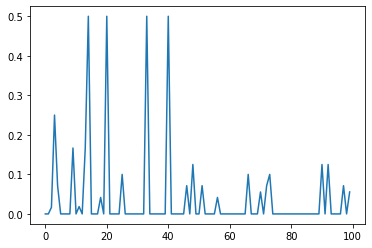

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(m1.predictions)), m1.pe)

In [30]:
p = np.divide(m1.predictions,[i * m for (m, i ) in m1.contexts_obrvd])
o = np.divide(m1.bx_obsrvd,[i * m for (m, i ) in m1.contexts_obrvd])
print(p)
print(o)

[0.  1.  0.5 0.5 1. ]
[0.75   0.8    0.4375 0.4375 0.75  ]


In [36]:
abs(p-o)

array([0.75  , 0.2   , 0.0625, 0.0625, 0.25  ])

In [35]:
abs(p-o)[-3:].mean()


0.125

In [26]:
m1.predictions

[0.0, 10.0, 16.0, 8.0, 16.0]